## Air Quality Index Prediction with LSTM Model

In [22]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from aqi_cal import ret, ret_future

# Load the dataset
data = pd.read_csv('./data/history_data.csv')

# Display the first few rows of the dataset to inspect the data
print(data.head())


              DateTime  AQI       CO    NO    NO2     O3    SO2   PM2.5  \
0  2020-11-25 01:00:00    5  2296.45  0.10  63.06  12.16  25.99  417.26   
1  2020-11-25 02:00:00    5  2323.15  0.73  71.97  10.01  29.80  415.69   
2  2020-11-25 03:00:00    5  2616.88  8.16  87.74  15.38  37.19  430.46   
3  2020-11-25 04:00:00    5  2216.34  8.27  80.20  62.23  54.84  383.96   
4  2020-11-25 05:00:00    5  1895.90  9.72  71.97  85.12  50.55  297.80   

     PM10   NH3  
0  457.27  4.81  
1  457.57  6.59  
2  477.49  8.36  
3  422.14  5.07  
4  331.37  8.49  


In [13]:
# Check the data types of the columns to identify which are non-numeric
print(data.dtypes)

# Select only the numeric columns for filling missing values
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Fill missing values in only the numeric columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Display the first few rows to verify
print(data.head())


DateTime     object
AQI           int64
CO          float64
NO          float64
NO2         float64
O3          float64
SO2         float64
PM2.5       float64
PM10        float64
NH3         float64
dtype: object
              DateTime  AQI       CO    NO    NO2     O3    SO2   PM2.5  \
0  2020-11-25 01:00:00    5  2296.45  0.10  63.06  12.16  25.99  417.26   
1  2020-11-25 02:00:00    5  2323.15  0.73  71.97  10.01  29.80  415.69   
2  2020-11-25 03:00:00    5  2616.88  8.16  87.74  15.38  37.19  430.46   
3  2020-11-25 04:00:00    5  2216.34  8.27  80.20  62.23  54.84  383.96   
4  2020-11-25 05:00:00    5  1895.90  9.72  71.97  85.12  50.55  297.80   

     PM10   NH3  
0  457.27  4.81  
1  457.57  6.59  
2  477.49  8.36  
3  422.14  5.07  
4  331.37  8.49  


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32659 entries, 0 to 32658
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  32659 non-null  object 
 1   AQI       32659 non-null  int64  
 2   CO        32659 non-null  float64
 3   NO        32659 non-null  float64
 4   NO2       32659 non-null  float64
 5   O3        32659 non-null  float64
 6   SO2       32659 non-null  float64
 7   PM2.5     32659 non-null  float64
 8   PM10      32659 non-null  float64
 9   NH3       32659 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.5+ MB


In [16]:
# Select the relevant pollutant columns for forecasting
pollutant_features = ['PM10', 'PM2.5', 'CO', 'SO2', 'NH3', 'O3']

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the data
scaled_data = scaler.fit_transform(data[pollutant_features])

# Create a DataFrame for the scaled data
scaled_data_df = pd.DataFrame(scaled_data, columns=pollutant_features, index=data.index)

# Display the scaled data
print(scaled_data_df.head())


       PM10     PM2.5        CO       SO2       NH3        O3
0  0.954820  0.484383  0.264445  0.090986  0.073034  0.931889
1  0.954847  0.482554  0.267819  0.104913  0.100061  0.931689
2  0.956666  0.499755  0.304934  0.131927  0.126936  0.932189
3  0.951612  0.445601  0.254323  0.196447  0.076981  0.936550
4  0.943323  0.345259  0.213833  0.180765  0.128910  0.938680


In [17]:
# Define the sequence length (how many past hours to use for prediction)
SEQ_LENGTH = 120

# Function to create sequences of time steps
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

# Create sequences from the scaled data
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split the data into training and testing sets (80% train, 20% test)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Print the shapes of the training and test sets
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(26031, 120, 6) (26031, 6) (6508, 120, 6) (6508, 6)


In [23]:
# Rebuild the LSTM model with changes
model = Sequential()

# First LSTM layer with fewer units and Dropout regularization
model.add(LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, len(pollutant_features))))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

# Output layer for predicting 6 pollutants
model.add(Dense(len(pollutant_features)))

# Compile the model using Adam optimizer with gradient clipping
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)  # Clipping the gradients
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Print model summary
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 120, 100)       │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 120, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,806 (483.62 KB)

 Trainable params: 123,806 (483.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - loss: 0.0212 - val_loss: 0.0027
Epoch 2/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 3/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 0.0031 - val_loss: 9.3070e-04
Epoch 4/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 0.0024 - val_loss: 7.8310e-04
Epoch 5/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 44s 107ms/step - loss: 0.0020 - val_loss: 7.1910e-04
Epoch 6/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 44s 107ms/step - loss: 0.0017 - val_loss: 6.4180e-04
Epoch 7/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 43s 106ms/step - loss: 0.0015 - val_loss: 6.6537e-04
Epoch 8/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 43s 105ms/step - loss: 0.0013 - val_loss: 5.9794e-04
Epoch 9/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 42s 103ms/step - loss: 0.0012 - val_loss: 5.4885e-04
Epoch 10/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 39s 95ms/step - loss: 0.0011 - val_loss: 5.5122e-04
Epoch 11/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 40s 99ms/step - loss: 9.5421e-04 - va

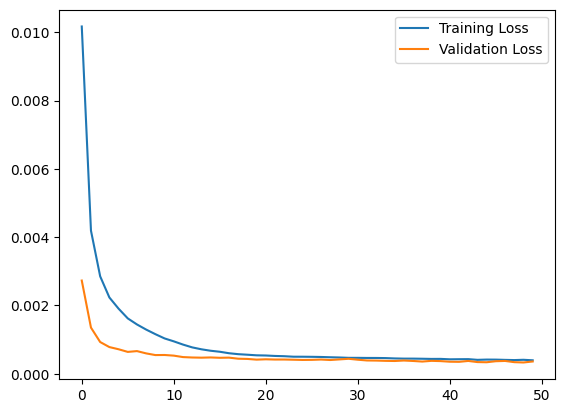

In [24]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plot the training and validation loss to see how the model performs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [27]:
# Predict the pollutant levels for the next 8 hours based on the current values
def predict_next_8_hours(model, scaler, current_values, seq_length=SEQ_LENGTH, forecast_hours=8):
    predictions = []
    current_input = np.repeat(current_values, seq_length, axis=0)
    
    for _ in range(forecast_hours):
        current_input = np.reshape(current_input, (1, seq_length, len(pollutant_features)))
        predicted_pollutants = model.predict(current_input)
        
        # Inverse transform the predicted pollutants to their original scale
        predicted_pollutants = scaler.inverse_transform(predicted_pollutants)
        
        # Append the predictions
        predictions.append(predicted_pollutants[0])
        
        # Update the input for the next prediction
        current_input = np.append(current_input[:, 1:, :], predicted_pollutants.reshape(1, 1, len(pollutant_features)), axis=1)
    
    return np.array(predictions)

# Assume current_values is a numpy array of shape (1, len(pollutant_features)) with the latest pollutant data
current_values = np.array([[37.63, 16.93, 9.45, 2.32, 0, 1.29]])  # Example values for PM10, PM2.5, CO, SO2, NH3, O3 
# "PM10": "37.63",
# "PM2.5": "16.93",
# "SO2": "2.32",
# "NO2": "5.38",
# "CO": "9.45",
# "O3": "1.29",

# Scale the current values
current_values_scaled = scaler.transform(current_values)

# Predict the next 8 hours
predicted_pollutants = predict_next_8_hours(model, scaler, current_values_scaled)

# Print the forecasted pollutant levels for the next 8 hours
for i, forecast in enumerate(predicted_pollutants, 1):
    print(f"Hour {i}: PM10={forecast[0]:.2f}, PM2.5={forecast[1]:.2f}, CO={forecast[2]:.2f}, SO2={forecast[3]:.2f}, NH3={forecast[4]:.2f}, O3={forecast[5]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Hour 1: PM10=24.72, PM2.5=17.33, CO=-2.68, SO2=1.26, NH3=-0.47, O3=24.87
Hour 2: PM10=1675.10, PM2.5=1523.51, CO=3024.39, SO2=-67.70, NH3=-27.35, O3=816.96
Hour 3: PM10=1822.30, PM2.5=1647.55, CO=15884.60, SO2=241.88, NH3=-3.78, O3=-205.59
Hour 4: PM10=1629.63, PM2.5=1374.01, CO=18070.15, SO2=453.34, NH3=-5.07, O3=-238.76
Hour 5: PM10=1749.17, PM2.5=1386.84, CO=18516.23, SO2=296.97, NH3=-14.65, O3=183.55
Hour 6: PM10=1811.56, PM2.5=1340.86, CO=20058.94, SO2=282.48, NH3=-10.82, O3=177.54
Hour 7: PM10=1895.23, PM2.5=1411.47, CO=21080.09, SO2=272.48, NH3=-12.83, O3=210.22
Hour 8: PM10=1916.58, PM2.5=1406.68, CO=21341.24, SO2=265.15, NH3=-10.67, O3=212.27
